# Script to investigate data in json database
Metrics with Pearson correlation and visualization through scatter plots based on yearly data. \
Second part covers the investigation of the idea where we constantly distribute the yearly CO2 data to monthly values (turns out this is not useful).

In [1]:
import numpy as np
import pandas as pd
import sklearn
import json
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from scipy.stats import pearsonr
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

plt.rcParams.update({'font.size':14})

# Read database

In [2]:
# Import whole database
with open('../../data/database.json') as json_database:
    imported_database = json.load(json_database)


## Read Features
- Process to monthly dataframe and yearly dataframe

In [3]:
X = None 
for i in imported_database:
    feature = imported_database.get(i)
    if feature['sector'] != 'target_values' and feature['yearly_data'] == False:
        new_data = pd.read_json(imported_database[i]['data'])
        if X is None:
            X = new_data
        else:
            X = pd.concat([X, new_data], axis=1)

X['date'] = X.index

X = X.drop(['M_TomTomAverageCityCongestion', 'M_TomTomAverageDiffRatio_20_To_29', 'M_BASTMobRep_DiffRatio', 'M_AppleMobRep_DiffRatioDriving', 'M_GoogleMR_RetailRecreation', 'M_GoogleMR_GroceryPharmacy', 'M_GoogleMR_Parks', 'M_GoogleMR_TransitStations', 'M_GoogleMR_Workplaces', 'M_GoogleMR_Residential'], axis=1)


# Monthly features
X_monthly = X.copy()
X_monthly.date = pd.to_datetime(X_monthly.date).dt.to_period('m')
X_monthly = X_monthly[X_monthly.date >= '1991-01']
X_monthly = X_monthly[X_monthly.date <= '2020-06']


     
# Yearly features
X_yearly = X.copy()
X_yearly.date = pd.to_datetime(X_yearly.date).dt.to_period('y')
X_yearly = X_yearly[X_yearly.date > '1990']
X_yearly = X_yearly[X_yearly.date <= '2020']

#groupby year and sum up to NaN if NaN is part of data
X_yearly = X_yearly.groupby('date').apply(pd.Series.sum,skipna=False)

#drop all features that are only filled with NaNs
for column in X_yearly:
    if np.isnan(np.nanmean(X_yearly[column].values)):
        X_yearly = X_yearly.drop(column, axis=1)
        print(column)
        


## Read CO2

In [4]:
# Concat data from same sector
for i in imported_database:
    feature = imported_database.get(i)
    if feature['sector'] == 'target_values':
        y = pd.read_json(imported_database[i]['data'])
y = y[(y.index > 1990) & (y.index <= 2020)]

# Yearly values
- Numeric correlations with Pearson correlation
- Visualization with scatter plots

## Numeric Investigation

In [5]:
df = X_yearly
df['CO2'] = y['Mio.tonnes_CO2'].values
plt.figure(figsize=(24,20))
cor = df.corr(method='pearson')

df = df.drop('Deutschland', axis=1)
for column in df:
    if column != "CO2":
        df_tmp = pd.DataFrame({column:df[column], 'CO2': df['CO2']},index=df.index)
        
        df_tmp = df_tmp.dropna(axis=0)
        
        print('Pearson r: ', round(pearsonr(df_tmp['CO2'], df_tmp[column])[0],2), ', # valid samples (years): ', df_tmp.shape[0], ', ', column)
        
        

Pearson r:  -0.65 , # valid samples (years):  16 ,  M_BAST_AverTotalVehicPerCountingStation
Pearson r:  -1.0 , # valid samples (years):  2 ,  M_BaysisCount_AverTotalVehicPerCountingStation
Pearson r:  -0.64 , # valid samples (years):  16 ,  M_BAST_Bavaria_AverTotalVehicPerCountingStation
Pearson r:  -0.68 , # valid samples (years):  17 ,  M_KFZ
Pearson r:  -0.45 , # valid samples (years):  9 ,  M_AviationTotalStarts
Pearson r:  -0.8 , # valid samples (years):  9 ,  M_AviationTotalPassengernumberStarts
Pearson r:  -0.66 , # valid samples (years):  9 ,  M_AviationTotalWeightFreightsStarts
Pearson r:  -0.45 , # valid samples (years):  9 ,  M_AviationTotalLandings
Pearson r:  -0.8 , # valid samples (years):  9 ,  M_AviationTotalPassengernumberLandings
Pearson r:  -0.79 , # valid samples (years):  9 ,  M_AviationTotalWeightFreightsLandings
Pearson r:  0.44 , # valid samples (years):  29 ,  M_InlandShippingTotalTransportPerformance
Pearson r:  0.76 , # valid samples (years):  9 ,  M_ShipsGer

<Figure size 1728x1440 with 0 Axes>

## Visualization

### Person heat map

Text(0.5, 1.0, 'Pearson correlation')

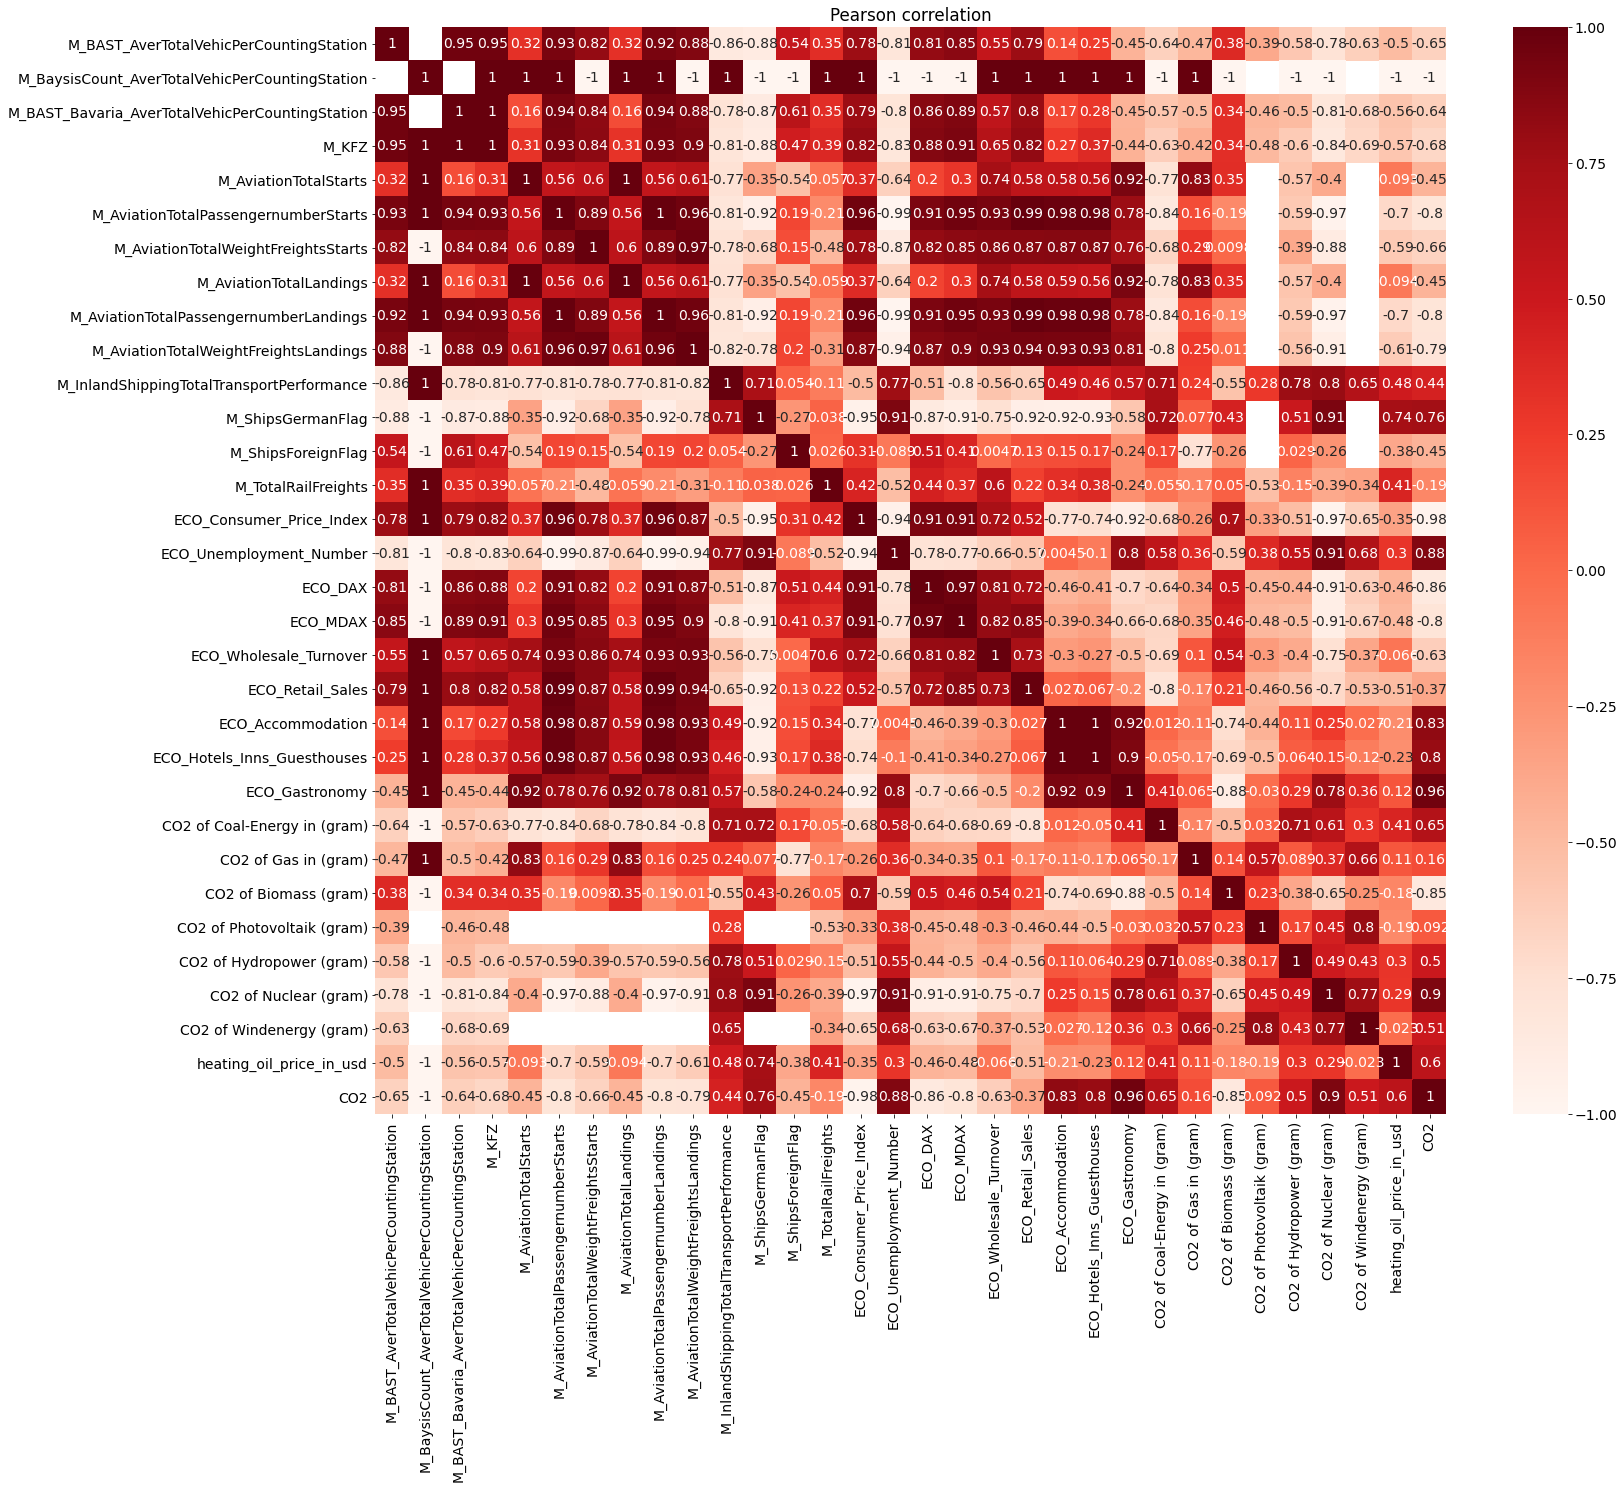

In [6]:
plt.figure(figsize=(24,20))
cor = df.corr(method='pearson')
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.title('Pearson correlation yearly data')

## Scatter plots

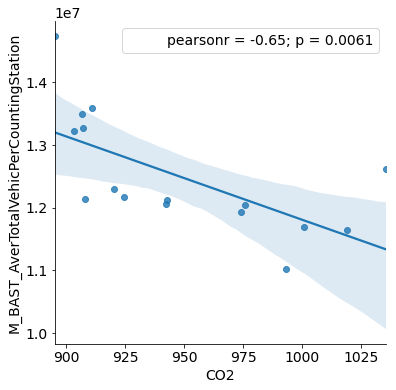

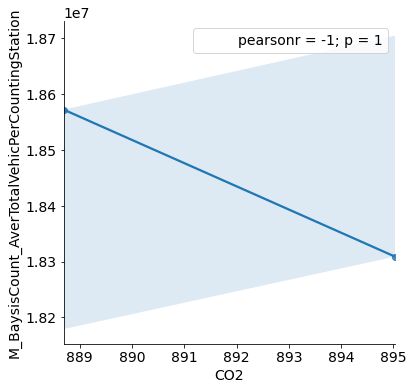

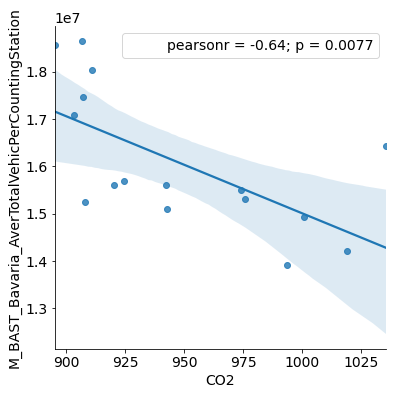

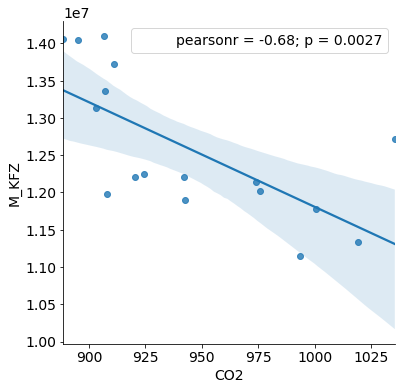

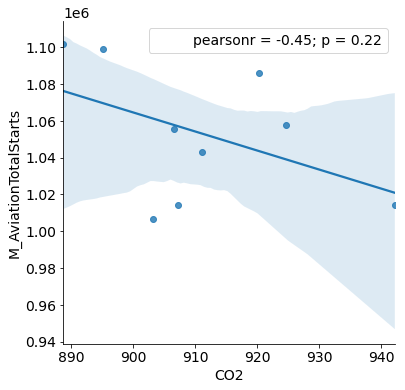

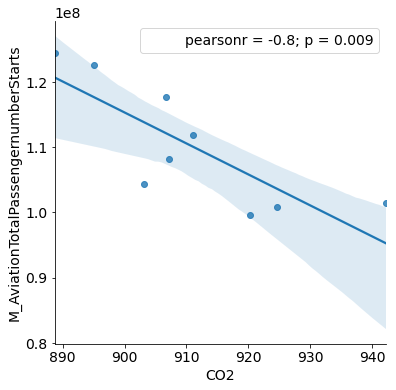

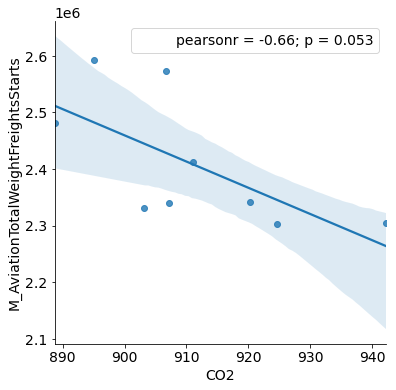

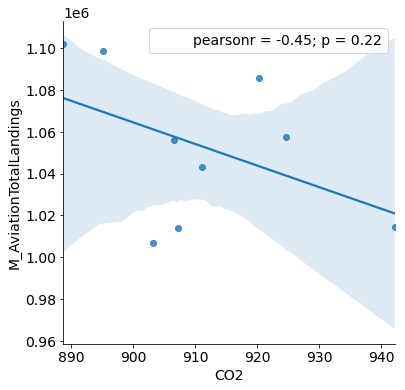

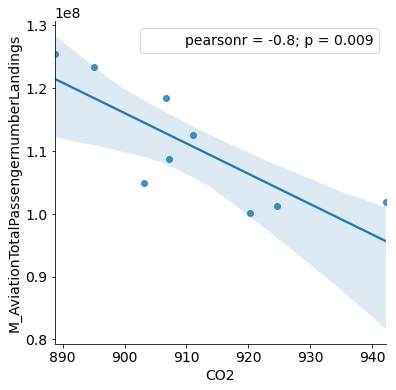

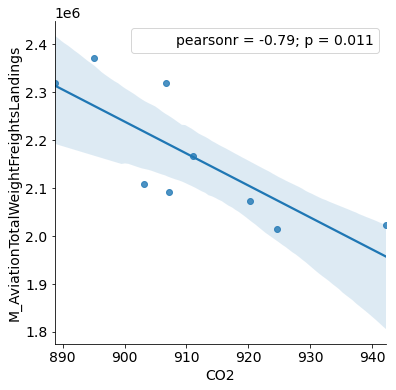

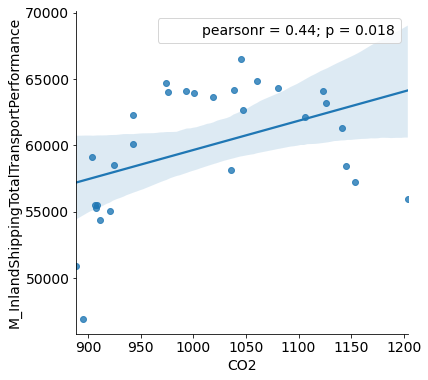

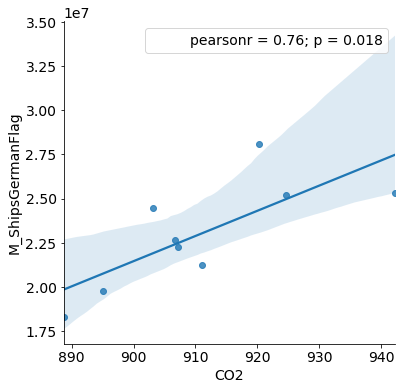

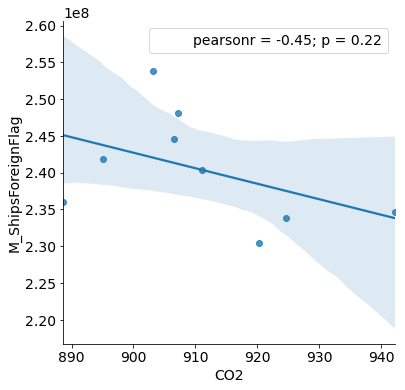

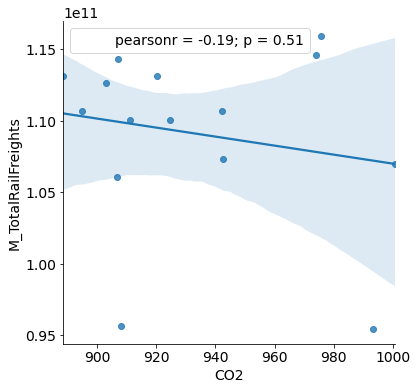

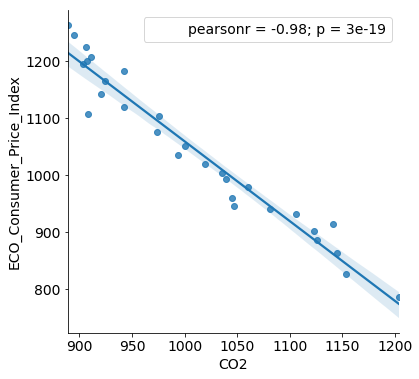

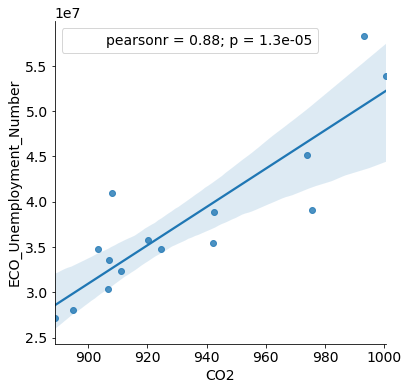

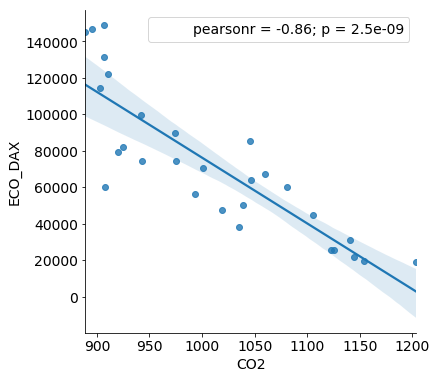

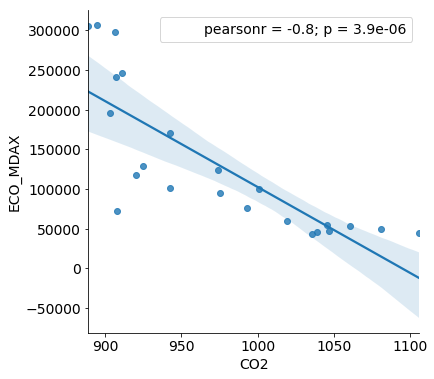

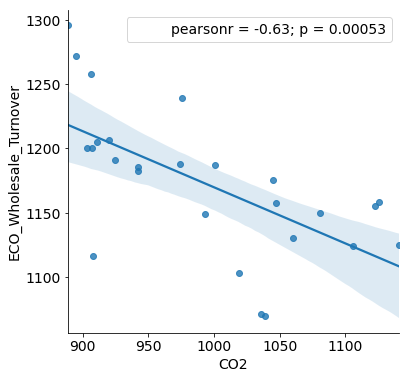

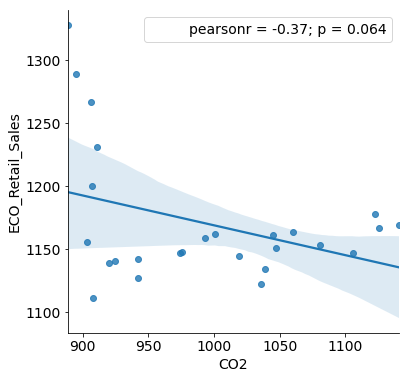

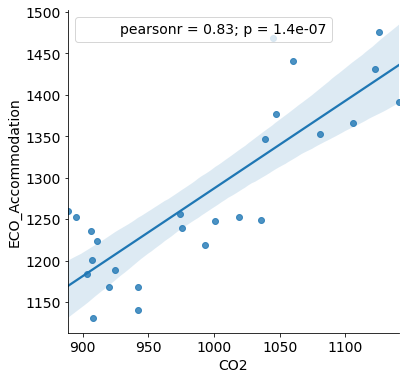

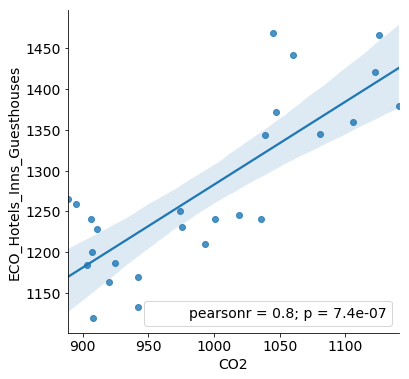

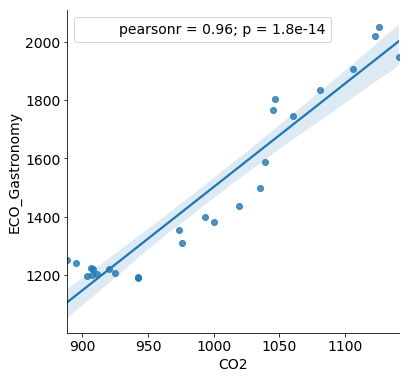

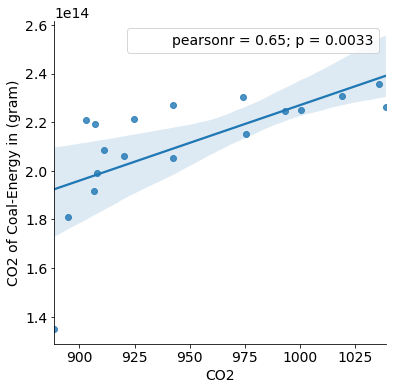

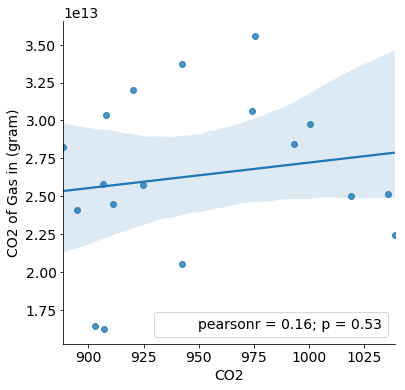

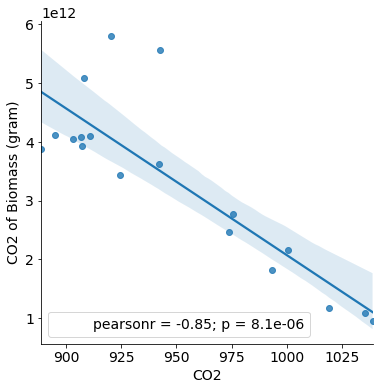

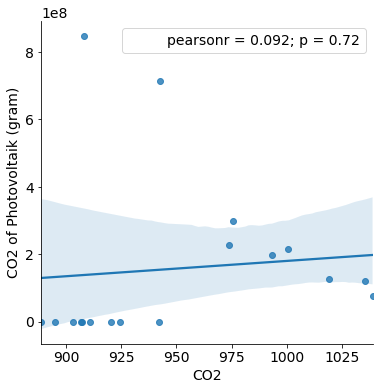

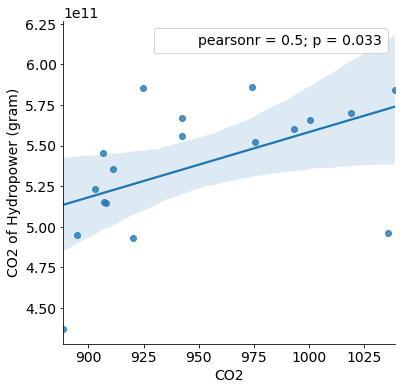

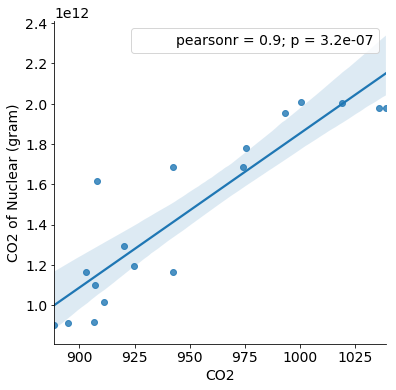

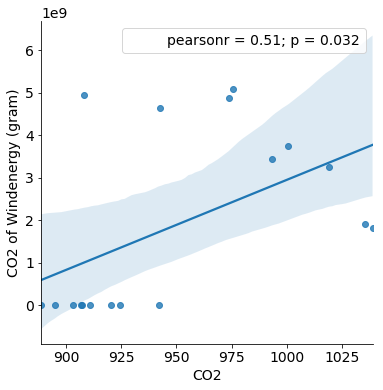

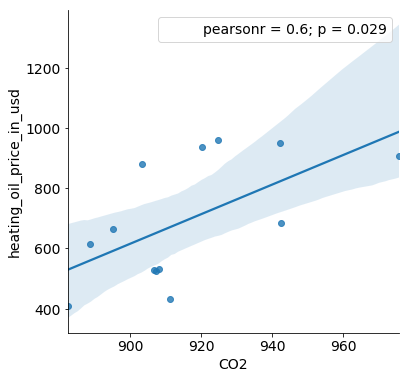

In [7]:
for column in df:
    if column != "CO2":
        df_tmp = pd.DataFrame({column:df[column], 'CO2': df['CO2']},index=df.index)
        
        df_tmp = df_tmp.dropna(axis=0)
        
        g = sns.JointGrid(x=df_tmp['CO2'],y=df_tmp[column], ratio=100)
        g.plot_joint(sns.regplot)
        g.annotate(stats.pearsonr)
        g.ax_marg_x.set_axis_off()
        g.ax_marg_y.set_axis_off()


# Monthly values
Yearly values of CO2 are divided by 12 to get constant distribution throughout the year.
- Numeric correlations with Pearson correlation
- Visualization with scatter plots

In [8]:
y.head()
monthlyCO2 = []
row,col = y.shape

for year in y.index:
    for k in range(0,12):
        monthlyCO2.append(y['Mio.tonnes_CO2'][year] / 12)

df = X_monthly
row,col = df.shape
df['CO2'] = monthlyCO2[:-6]

df = df.drop('date', axis=1)

## Numeric Investigation

In [9]:
df = df.drop('Deutschland', axis=1)
for column in df:
    if column != "CO2":
        df_tmp = pd.DataFrame({column:df[column], 'CO2': df['CO2']},index=df.index)
        df_tmp = df_tmp.dropna(axis=0)
        
        print('Pearson r: ', round(pearsonr(df_tmp['CO2'], df_tmp[column])[0],2), ', # valid samples (years): ', df_tmp.shape[0], ', ', column)
        
        

Pearson r:  -0.46 , # valid samples (years):  192 ,  M_BAST_AverTotalVehicPerCountingStation
Pearson r:  0.32 , # valid samples (years):  39 ,  M_BaysisCount_AverTotalVehicPerCountingStation
Pearson r:  -0.46 , # valid samples (years):  192 ,  M_BAST_Bavaria_AverTotalVehicPerCountingStation
Pearson r:  -0.42 , # valid samples (years):  210 ,  M_KFZ
Pearson r:  0.07 , # valid samples (years):  112 ,  M_AviationTotalStarts
Pearson r:  -0.14 , # valid samples (years):  112 ,  M_AviationTotalPassengernumberStarts
Pearson r:  -0.3 , # valid samples (years):  112 ,  M_AviationTotalWeightFreightsStarts
Pearson r:  0.07 , # valid samples (years):  112 ,  M_AviationTotalLandings
Pearson r:  -0.15 , # valid samples (years):  112 ,  M_AviationTotalPassengernumberLandings
Pearson r:  -0.49 , # valid samples (years):  112 ,  M_AviationTotalWeightFreightsLandings
Pearson r:  0.27 , # valid samples (years):  350 ,  M_InlandShippingTotalTransportPerformance
Pearson r:  0.63 , # valid samples (years): 

## Visualization

### Pearson heat map

Text(0.5, 1.0, 'Pearson correlation')

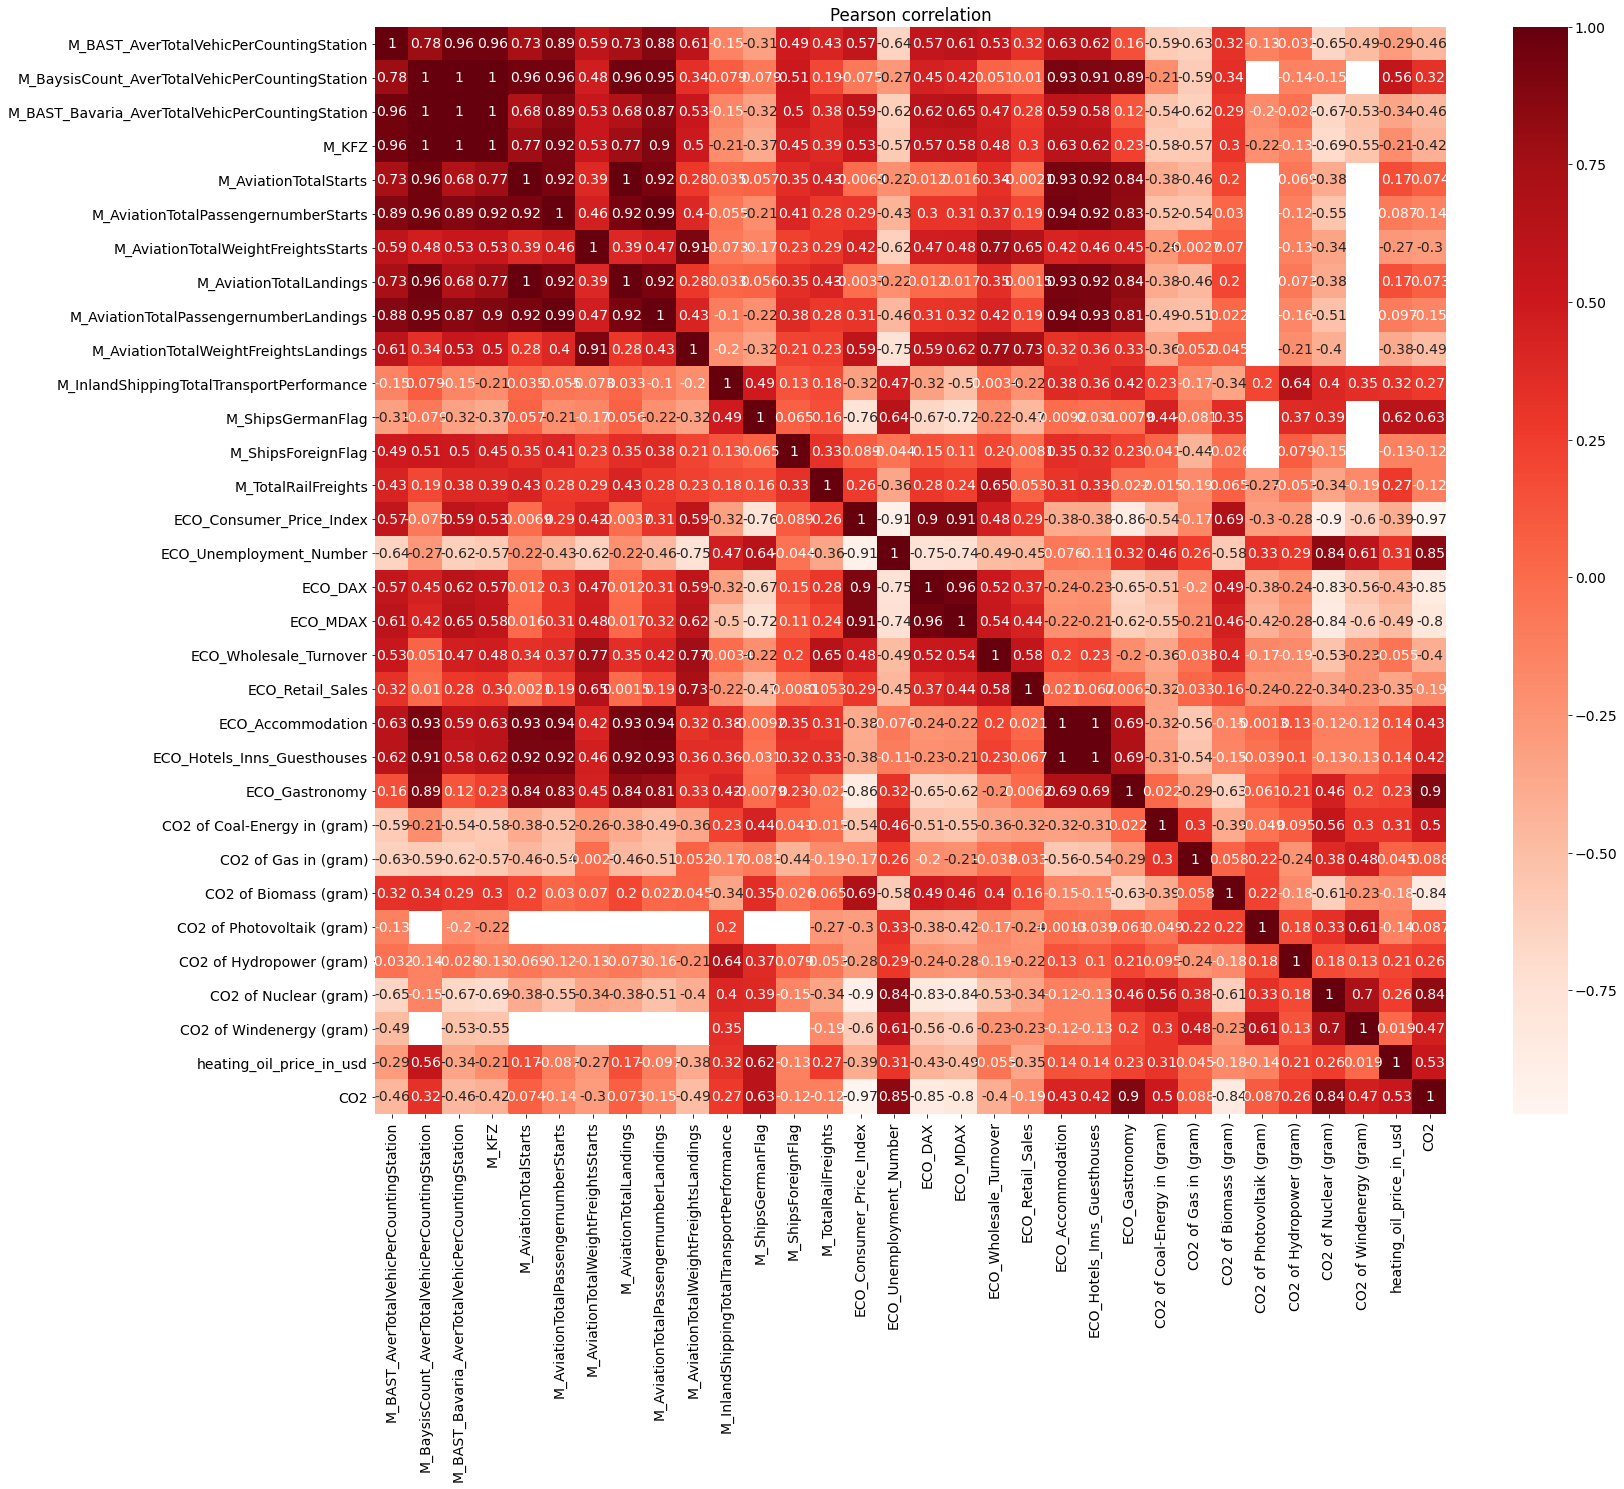

In [10]:
plt.figure(figsize=(24,20))
cor = df.corr(method='pearson')
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.title('Pearson correlation constant monthly values')

### Scatter plots

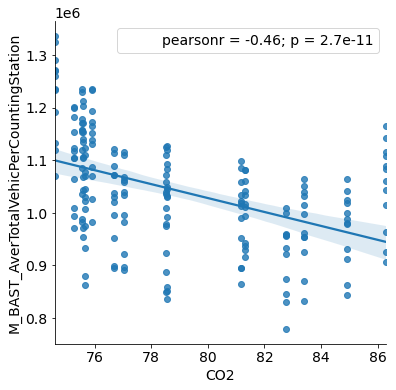

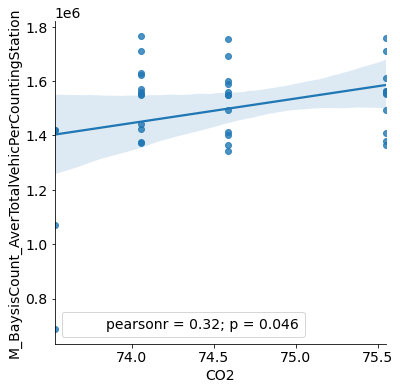

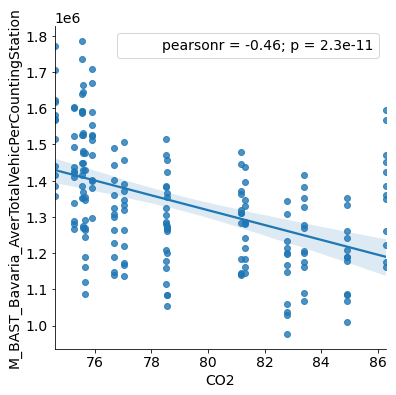

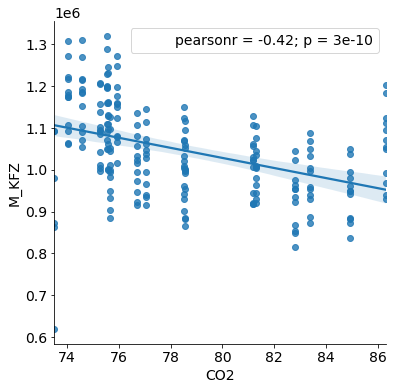

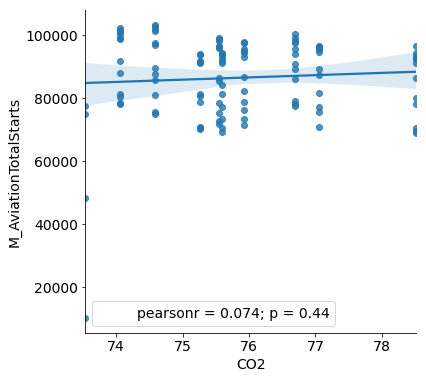

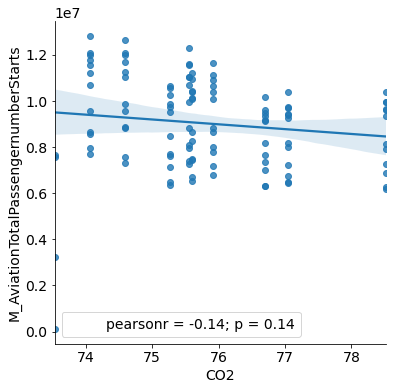

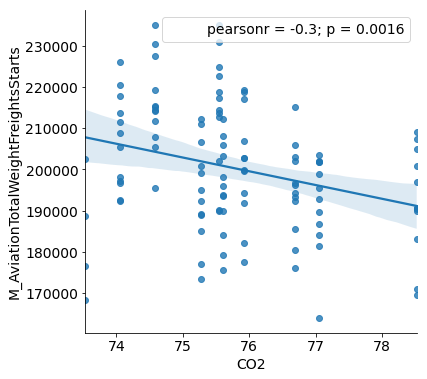

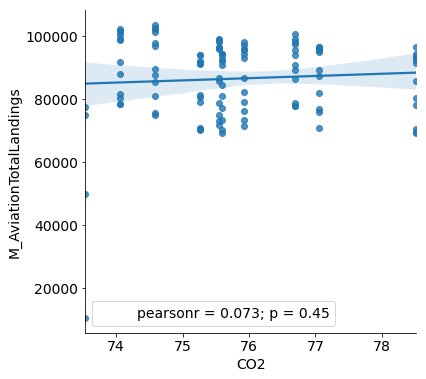

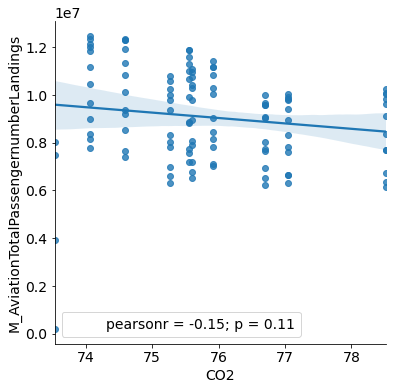

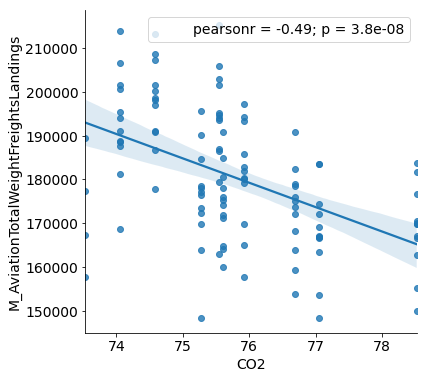

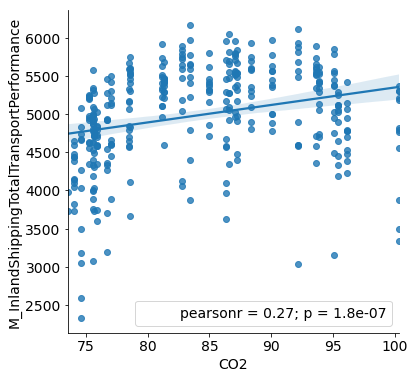

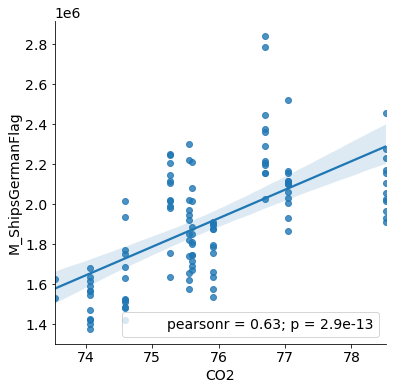

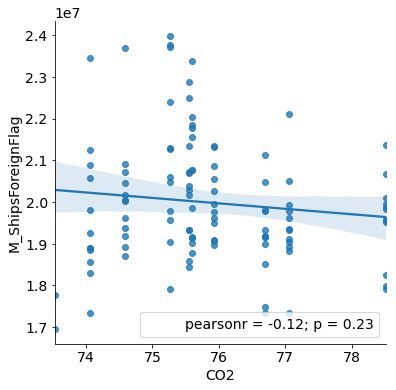

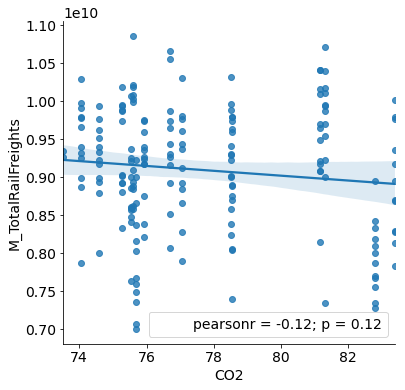

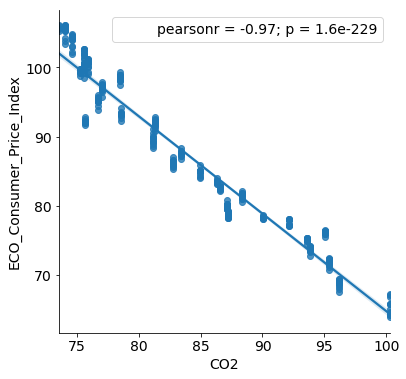

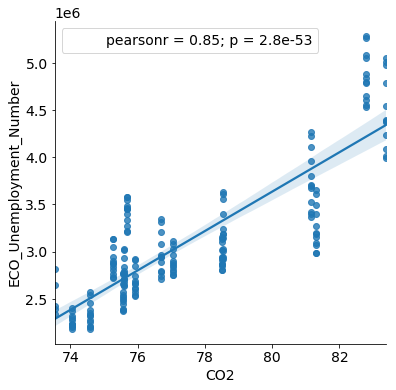

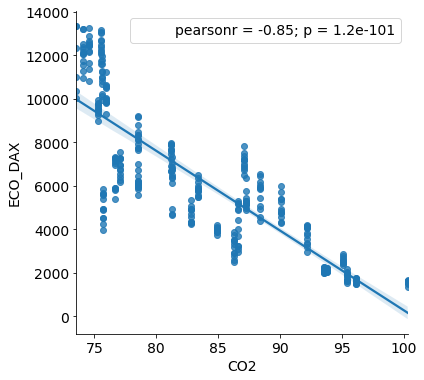

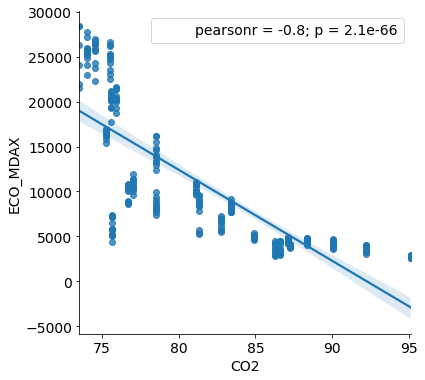

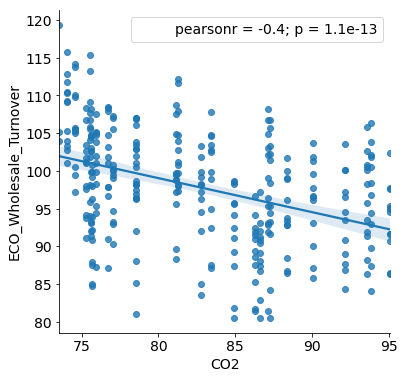

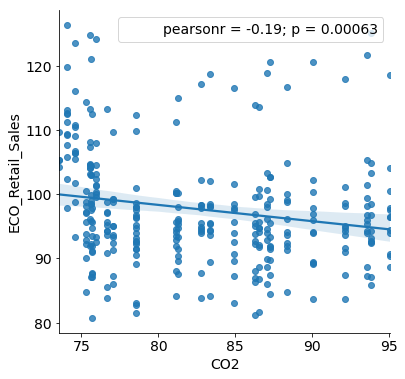

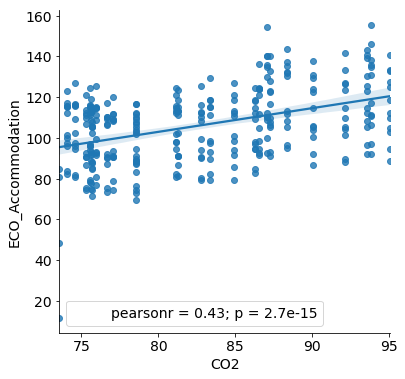

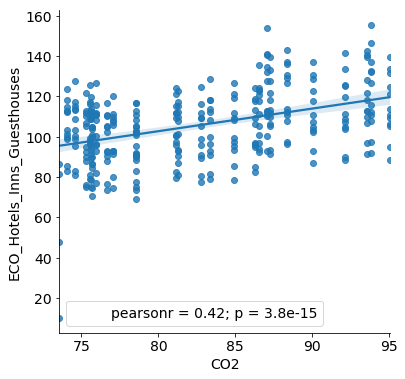

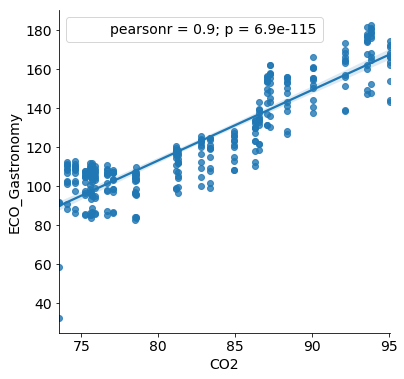

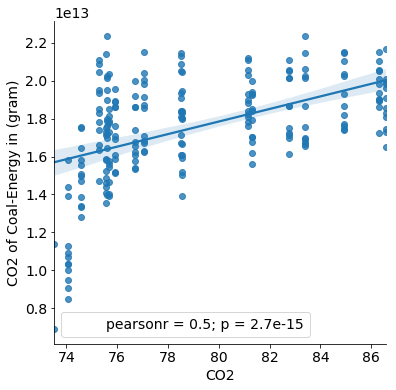

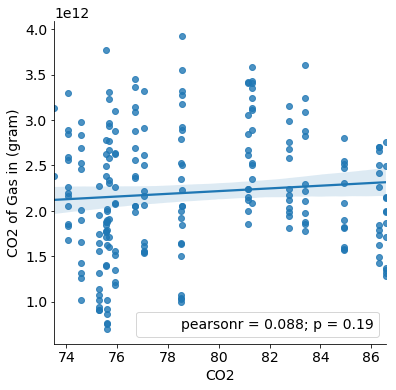

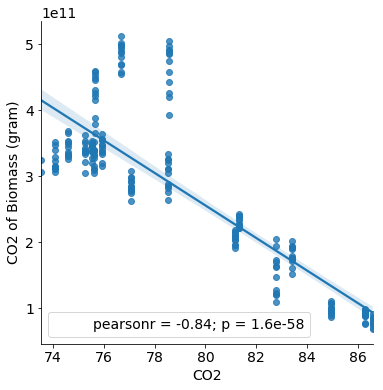

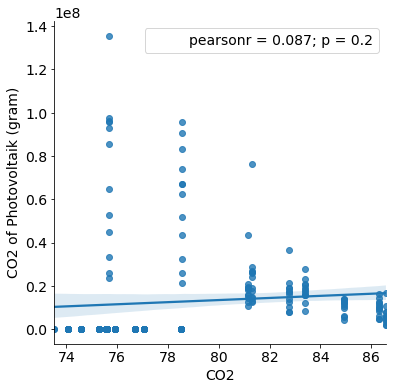

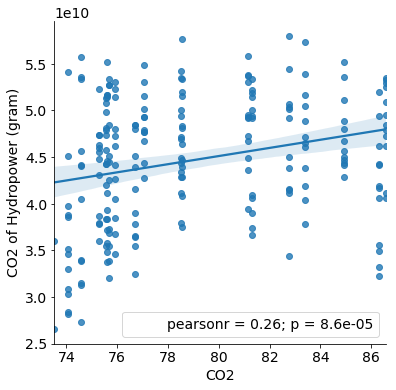

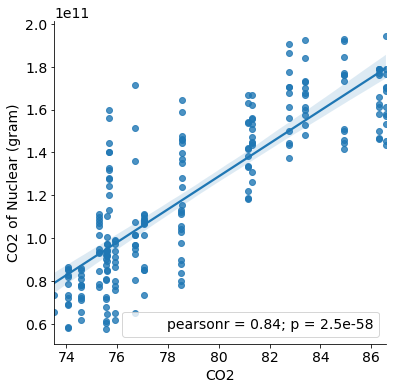

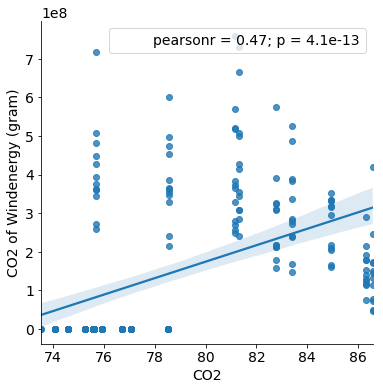

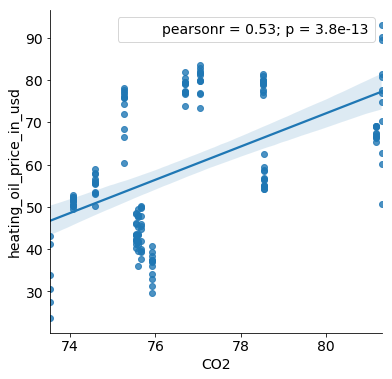

In [11]:
for column in df:
    if column != "CO2":
        df_tmp = pd.DataFrame({column:df[column], 'CO2': df['CO2']},index=df.index)
        
        df_tmp = df_tmp.dropna(axis=0)
        
        g = sns.JointGrid(x=df_tmp['CO2'],y=df_tmp[column], ratio=100)
        g.plot_joint(sns.regplot)
        g.annotate(stats.pearsonr)
        g.ax_marg_x.set_axis_off()
        g.ax_marg_y.set_axis_off()